In [1]:
import torch
import torch.nn as nn
import cv2
import multiprocessing
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.optim import Adam, AdamW
from torch.utils.data import random_split
from torchmetrics.classification import Accuracy
from tqdm import tqdm
from customDataset import CustomKineticsDataset
import matplotlib.pyplot as plt

from R2plus1 import R2plus1_with_attention, R2plus1_with_attention_v3, R2plus1_with_attention_v4

Download and transform dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 171)),  # Resize frames
    transforms.CenterCrop(112),     # Crop to 112x112
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pre-trained model
])

# Load the Kinetics dataset (assuming Kinetics400 is available)
#dataset = datasets.Kinetics(root="kinetics400_5per", frames_per_clip=16, step_between_clips=1, transform=transform)
dataset = CustomKineticsDataset(root_dir='kinetics400_5per/train',frames_per_clip=16,transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [3]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    drop_last=True, 
    num_workers=multiprocessing.cpu_count() // 2, 
    pin_memory=True,
    persistent_workers=True)

val_loader = DataLoader(val_dataset, 
    batch_size=32, 
    shuffle=False, 
    drop_last=True, 
    num_workers=multiprocessing.cpu_count() // 2, 
    pin_memory=True,
    persistent_workers=True)

In [4]:
model = R2plus1_with_attention_v4(nr_classes=400).cuda()
#optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss()
accuracy_metric = Accuracy(task="multiclass",num_classes=400).cuda()

In [5]:
num_epochs = 50

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        videos, labels = videos.cuda(), labels.cuda()
        optimizer.zero_grad()

        logits, _, _= model(videos) #

        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += accuracy_metric(logits, labels)

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f}", end='\r')
    torch.save(model, f'checkpoints/v4_checkpoints_2/R2plus1D_checkpoint_{epoch}.pt')
    


Epoch 1/50: 100%|██████████| 270/270 [29:48<00:00,  6.62s/it]


Epoch 2/50: 100%|██████████| 270/270 [29:55<00:00,  6.65s/it]


Epoch 3/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 4/50: 100%|██████████| 270/270 [29:48<00:00,  6.63s/it]


Epoch 5/50: 100%|██████████| 270/270 [29:56<00:00,  6.65s/it]


Epoch 6/50: 100%|██████████| 270/270 [29:20<00:00,  6.52s/it]


Epoch 7/50: 100%|██████████| 270/270 [29:28<00:00,  6.55s/it]


Epoch 8/50: 100%|██████████| 270/270 [29:51<00:00,  6.64s/it]


Epoch 9/50: 100%|██████████| 270/270 [29:49<00:00,  6.63s/it] 


Epoch 10/50: 100%|██████████| 270/270 [29:52<00:00,  6.64s/it]


Epoch 11/50: 100%|██████████| 270/270 [29:55<00:00,  6.65s/it]


Epoch 12/50: 100%|██████████| 270/270 [29:55<00:00,  6.65s/it]


Epoch 13/50: 100%|██████████| 270/270 [29:52<00:00,  6.64s/it]


Epoch 14/50: 100%|██████████| 270/270 [29:56<00:00,  6.65s/it]


Epoch 15/50: 100%|██████████| 270/270 [29:52<00:00,  6.64s/it]


Epoch 16/50: 100%|██████████| 270/270 [29:53<00:00,  6.64s/it]


Epoch 17/50: 100%|██████████| 270/270 [29:51<00:00,  6.64s/it]


Epoch 18/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 19/50: 100%|██████████| 270/270 [29:51<00:00,  6.63s/it]


Epoch 20/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 21/50: 100%|██████████| 270/270 [29:42<00:00,  6.60s/it] 


Epoch 22/50: 100%|██████████| 270/270 [29:08<00:00,  6.48s/it]


Epoch 23/50: 100%|██████████| 270/270 [29:09<00:00,  6.48s/it]


Epoch 24/50: 100%|██████████| 270/270 [29:31<00:00,  6.56s/it]


Epoch 25/50: 100%|██████████| 270/270 [29:53<00:00,  6.64s/it]


Epoch 26/50: 100%|██████████| 270/270 [29:49<00:00,  6.63s/it] 


Epoch 27/50: 100%|██████████| 270/270 [29:52<00:00,  6.64s/it]


Epoch 28/50: 100%|██████████| 270/270 [29:52<00:00,  6.64s/it]


Epoch 29/50: 100%|██████████| 270/270 [29:51<00:00,  6.63s/it]


Epoch 30/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 31/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 32/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 33/50: 100%|██████████| 270/270 [29:49<00:00,  6.63s/it]


Epoch 34/50: 100%|██████████| 270/270 [29:52<00:00,  6.64s/it]


Epoch 35/50: 100%|██████████| 270/270 [29:51<00:00,  6.63s/it]


Epoch 36/50: 100%|██████████| 270/270 [29:51<00:00,  6.64s/it]


Epoch 37/50: 100%|██████████| 270/270 [29:49<00:00,  6.63s/it]


Epoch 38/50: 100%|██████████| 270/270 [29:51<00:00,  6.63s/it]


Epoch 39/50: 100%|██████████| 270/270 [29:49<00:00,  6.63s/it]


Epoch 40/50: 100%|██████████| 270/270 [29:48<00:00,  6.62s/it]


Epoch 41/50: 100%|██████████| 270/270 [29:51<00:00,  6.63s/it] 


Epoch 42/50: 100%|██████████| 270/270 [29:49<00:00,  6.63s/it]


Epoch 43/50: 100%|██████████| 270/270 [29:54<00:00,  6.65s/it]


Epoch 44/50: 100%|██████████| 270/270 [29:51<00:00,  6.63s/it]


Epoch 45/50: 100%|██████████| 270/270 [29:49<00:00,  6.63s/it]


Epoch 46/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 47/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 48/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]


Epoch 49/50: 100%|██████████| 270/270 [29:49<00:00,  6.63s/it]


Epoch 50/50: 100%|██████████| 270/270 [29:50<00:00,  6.63s/it]

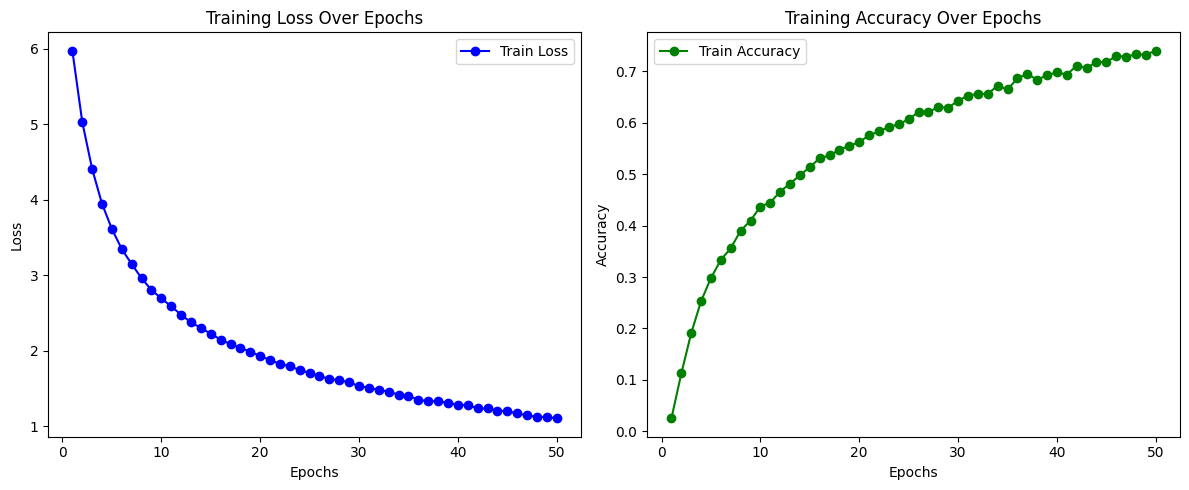

In [6]:
def plot_metrics(train_losses, train_accuracies):
    # Convert all elements to CPU floats if they are tensors
    train_losses = [t.cpu().item() if hasattr(t, 'device') else t for t in train_losses]
    train_accuracies = [t.cpu().item() if hasattr(t, 'device') else t for t in train_accuracies]

    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='b', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='g', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example call after training
plot_metrics(train_losses, train_accuracies)

In [7]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "everything.pt")

Train it again for a few more epochs:

In [8]:
model = R2plus1_with_attention_v4(nr_classes=400).cuda() 
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

checkpoint = torch.load("everything.pt")

#model = torch.load("checkpoints/v4_checkpoints/R2plus1D_checkpoint_29.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.train()

num_epochs = 50

train_losses_extra = []
train_accuracies_extra = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        videos, labels = videos.cuda(), labels.cuda()
        optimizer.zero_grad()

        # Forward pass
        logits, _, _ = model(videos)

        # Compute the loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        train_accuracy += accuracy_metric(logits, labels)

    # Print epoch summary
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    train_losses_extra.append(train_loss)
    train_accuracies_extra.append(train_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f}", end='\r')
    torch.save(model, f'checkpoints/v4_checkpoints_extra/R2plus1D_checkpoint_{epoch}.pt')

/tmp/ipykernel_2189708/4105285100.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("everything.pt")
Epoch 1/50: 100%|██████████| 270/270 [29:57<00

Epoch 2/50: 100%|██████████| 270/270 [29:58<00:00,  6.66s/it]


Epoch 3/50: 100%|██████████| 270/270 [29:59<00:00,  6.66s/it]


Epoch 4/50: 100%|██████████| 270/270 [29:59<00:00,  6.66s/it]


Epoch 5/50: 100%|██████████| 270/270 [30:04<00:00,  6.68s/it]


Epoch 6/50: 100%|██████████| 270/270 [30:06<00:00,  6.69s/it] 


Epoch 7/50: 100%|██████████| 270/270 [30:12<00:00,  6.71s/it]


Epoch 8/50: 100%|██████████| 270/270 [30:14<00:00,  6.72s/it]


Epoch 9/50: 100%|██████████| 270/270 [30:14<00:00,  6.72s/it]


Epoch 10/50: 100%|██████████| 270/270 [30:08<00:00,  6.70s/it] 


Epoch 11/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it] 


Epoch 12/50: 100%|██████████| 270/270 [30:12<00:00,  6.71s/it]


Epoch 13/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 14/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 15/50: 100%|██████████| 270/270 [30:08<00:00,  6.70s/it]


Epoch 16/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 17/50: 100%|██████████| 270/270 [30:07<00:00,  6.69s/it]


Epoch 18/50: 100%|██████████| 270/270 [30:04<00:00,  6.68s/it]


Epoch 19/50: 100%|██████████| 270/270 [30:06<00:00,  6.69s/it] 


Epoch 20/50: 100%|██████████| 270/270 [30:08<00:00,  6.70s/it]


Epoch 21/50: 100%|██████████| 270/270 [30:08<00:00,  6.70s/it]


Epoch 22/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 23/50: 100%|██████████| 270/270 [30:05<00:00,  6.69s/it]


Epoch 24/50: 100%|██████████| 270/270 [30:10<00:00,  6.70s/it]


Epoch 25/50: 100%|██████████| 270/270 [30:06<00:00,  6.69s/it]


Epoch 26/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 27/50: 100%|██████████| 270/270 [30:06<00:00,  6.69s/it]


Epoch 28/50: 100%|██████████| 270/270 [30:10<00:00,  6.70s/it]


Epoch 29/50: 100%|██████████| 270/270 [30:08<00:00,  6.70s/it]


Epoch 30/50: 100%|██████████| 270/270 [30:07<00:00,  6.70s/it] 


Epoch 31/50: 100%|██████████| 270/270 [30:08<00:00,  6.70s/it]


Epoch 32/50: 100%|██████████| 270/270 [30:07<00:00,  6.70s/it] 


Epoch 33/50: 100%|██████████| 270/270 [30:06<00:00,  6.69s/it]


Epoch 34/50: 100%|██████████| 270/270 [30:05<00:00,  6.69s/it]


Epoch 35/50: 100%|██████████| 270/270 [30:05<00:00,  6.69s/it]


Epoch 36/50: 100%|██████████| 270/270 [30:06<00:00,  6.69s/it]


Epoch 37/50: 100%|██████████| 270/270 [30:07<00:00,  6.69s/it]


Epoch 38/50: 100%|██████████| 270/270 [30:07<00:00,  6.70s/it]


Epoch 39/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 40/50: 100%|██████████| 270/270 [30:05<00:00,  6.69s/it]


Epoch 41/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 42/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it] 


Epoch 43/50: 100%|██████████| 270/270 [30:10<00:00,  6.70s/it]


Epoch 44/50: 100%|██████████| 270/270 [30:07<00:00,  6.70s/it]


Epoch 45/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 46/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it]


Epoch 47/50: 100%|██████████| 270/270 [30:06<00:00,  6.69s/it]


Epoch 48/50: 100%|██████████| 270/270 [30:11<00:00,  6.71s/it]


Epoch 49/50: 100%|██████████| 270/270 [30:11<00:00,  6.71s/it]


Epoch 50/50: 100%|██████████| 270/270 [30:09<00:00,  6.70s/it] 

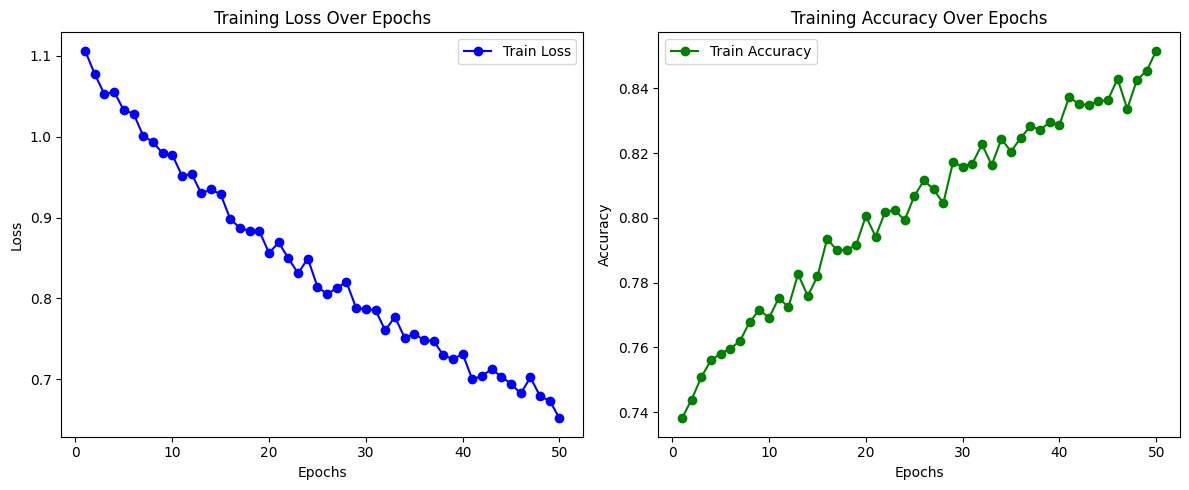

In [9]:
plot_metrics(train_losses_extra, train_accuracies_extra)

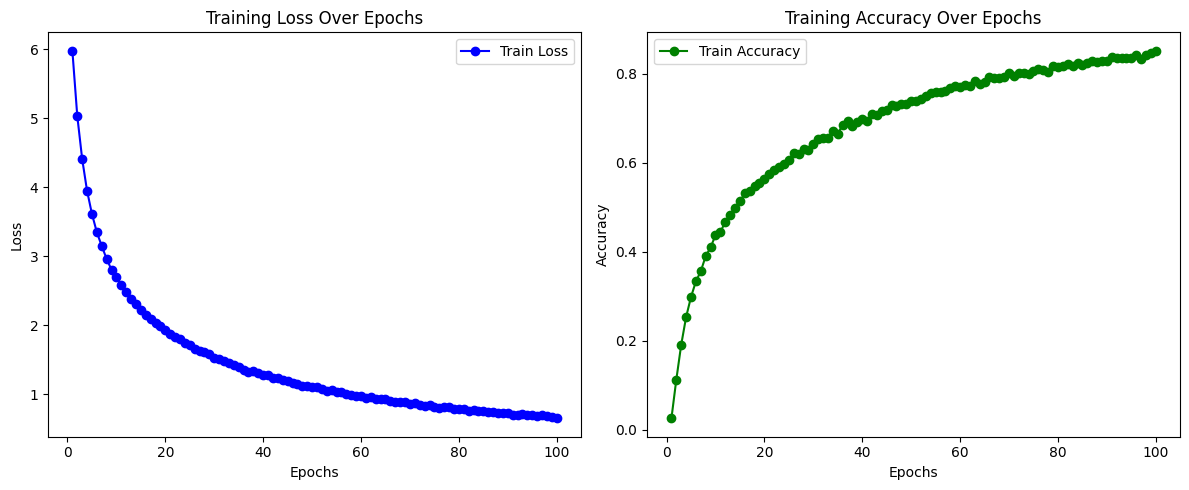

In [11]:
loss_all = train_losses + train_losses_extra
acc_all = train_accuracies + train_accuracies_extra
plot_metrics(loss_all,acc_all)

In [10]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "everything_2.pt")

I didn't change the files name, so the last one is checkpoint 1.

In [5]:
checkpoint = torch.load('everything_2.pt')
model.load_state_dict(checkpoint['model_state_dict'])
#model = torch.load("checkpoints_third_run/R2plus1D_checkpoint 1.pt")

/tmp/ipykernel_3444787/3849978378.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('everything_2.pt')


<All keys matched successfully>

In [19]:
num_epochs = 5
for epoch in range(num_epochs):
# Validation loop
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0

    with torch.no_grad():
        for videos, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            videos, labels = videos.cuda(), labels.cuda()

            # Forward pass
            logits, _, _ = model(videos)

            # Compute the loss
            loss = criterion(logits, labels)

            # Track loss and accuracy
            val_loss += loss.item()
            val_accuracy += accuracy_metric(logits, labels)

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    print(f"Validation - Loss: {val_loss:.4f} - Accuracy: {val_accuracy:.4f}")

Epoch 1/5: 100%|██████████| 33/33 [07:06<00:00, 12.93s/it]


Validation - Loss: 0.4819 - Accuracy: 0.9167


Epoch 2/5: 100%|██████████| 33/33 [07:05<00:00, 12.88s/it]


Validation - Loss: 0.4964 - Accuracy: 0.9086


Epoch 3/5: 100%|██████████| 33/33 [07:05<00:00, 12.90s/it]


Validation - Loss: 0.4991 - Accuracy: 0.9077


Epoch 4/5: 100%|██████████| 33/33 [07:05<00:00, 12.88s/it]


Validation - Loss: 0.4958 - Accuracy: 0.9110


Epoch 5/5: 100%|██████████| 33/33 [07:04<00:00, 12.88s/it]

Validation - Loss: 0.4881 - Accuracy: 0.9029


## Run inference:

In [6]:
def load_video_frames(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(num_frames):
        frame_idx = int(i * (frame_count / num_frames))  # Sample evenly
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(frame)

    cap.release()
    return frames  # List of (H, W, C) numpy arrays

In [7]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

def preprocess_frames_2(frames):
    transform = transforms.Compose([
        transforms.Resize((128, 171)),  # Resize the frames
        transforms.CenterCrop(112),     # Crop the frames to 112x112
        transforms.ToTensor(),          # Convert frames to tensor (values scaled to [0, 1])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        transforms.ConvertImageDtype(torch.float32)  # Convert to float32
    ])

    processed_frames = []
    for frame in frames:
        pil_frame = Image.fromarray(frame)
        
        # Apply the transformation (which includes scaling to [0, 1], normalizing, and converting to float32)
        processed_frame = transform(pil_frame)
        
        # Clip values to [0, 1] after normalization (if necessary)
        processed_frame = torch.clamp(processed_frame, 0, 1)

        processed_frames.append(processed_frame)

    # Stack frames → Shape: (T, C, H, W) → (16, 3, 112, 112)
    video_tensor = torch.stack(processed_frames)

    # Rearrange dimensions to (B, C, T, H, W) → (1, 3, 16, 112, 112)
    return video_tensor.permute(1, 0, 2, 3).unsqueeze(0)


In [8]:
from PIL import Image

def preprocess_frames(frames):
    transform = transforms.Compose([
        transforms.Resize((128, 171)),  
        transforms.CenterCrop(112),     
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    
    # Convert NumPy frames to PIL images and apply transforms
    processed_frames = [transform(Image.fromarray(frame)) for frame in frames]  
    
    # Stack frames → Shape: (T, C, H, W) → (16, 3, 112, 112)
    video_tensor = torch.stack(processed_frames)  
    print(f'Before: {video_tensor.shape}')
    # Rearrange dimensions to (B, C, T, H, W) → (1, 3, 16, 112, 112)
    return video_tensor.permute(1, 0, 2, 3).unsqueeze(0)  


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_path = "kinetics400_5per/train/archery/J6YU92u-Dxs.mp4"
frames = load_video_frames(video_path)
if len(frames) < 16:
    print("Warning: Not enough frames. Consider padding or skipping the video.")
inputs = preprocess_frames_2(frames).to(device) 
print(f'After: {inputs.shape}')

After: torch.Size([1, 3, 16, 112, 112])


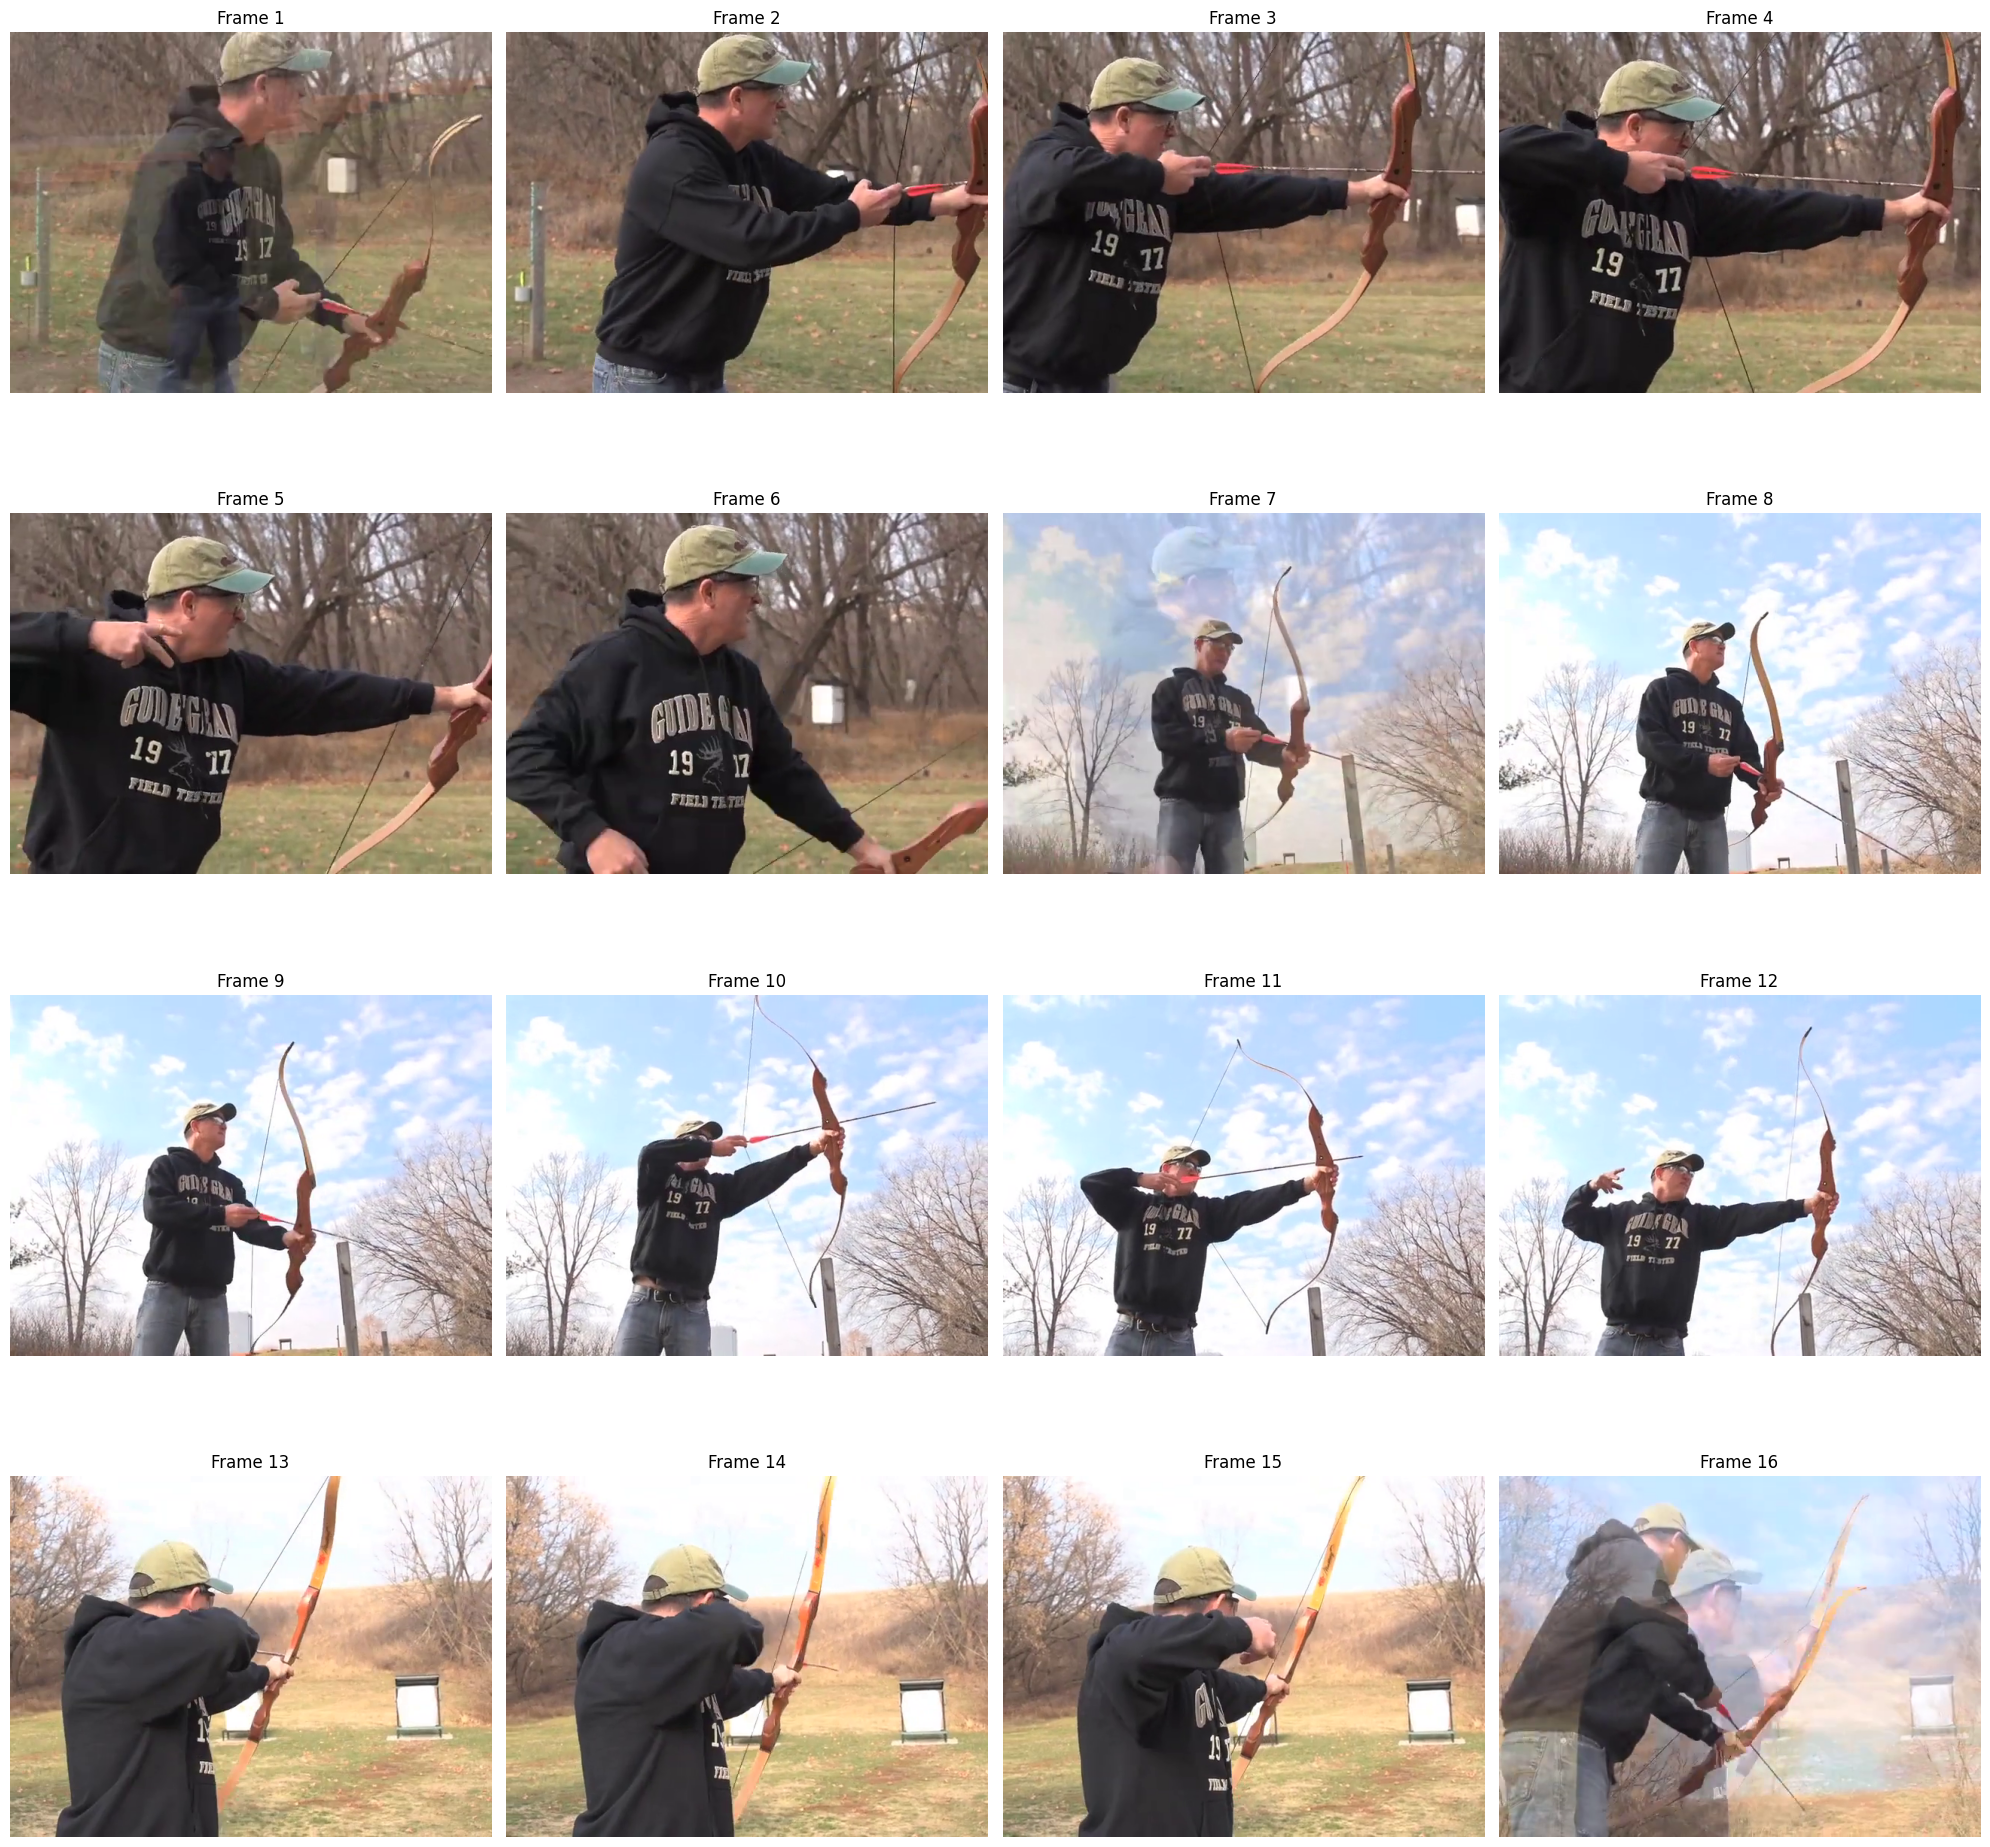

In [10]:
import matplotlib.pyplot as plt

def show_frames_from_list(frame_list):

    num_frames = len(frame_list)
    
    # Calculate number of rows and columns for subplots (assuming square layout)
    rows = int(num_frames**0.5)
    cols = (num_frames + rows - 1) // rows  # Round up to fill the grid
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    
    axes = axes.flatten()

    for i in range(num_frames):
        frame = frame_list[i]  # Shape: (480, 640, 3)
        
        axes[i].imshow(frame)
        axes[i].axis("off")  # Hide axes for better visualization
        axes[i].set_title(f"Frame {i+1}")
    
    for i in range(num_frames, len(axes)):
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

show_frames_from_list(frames)

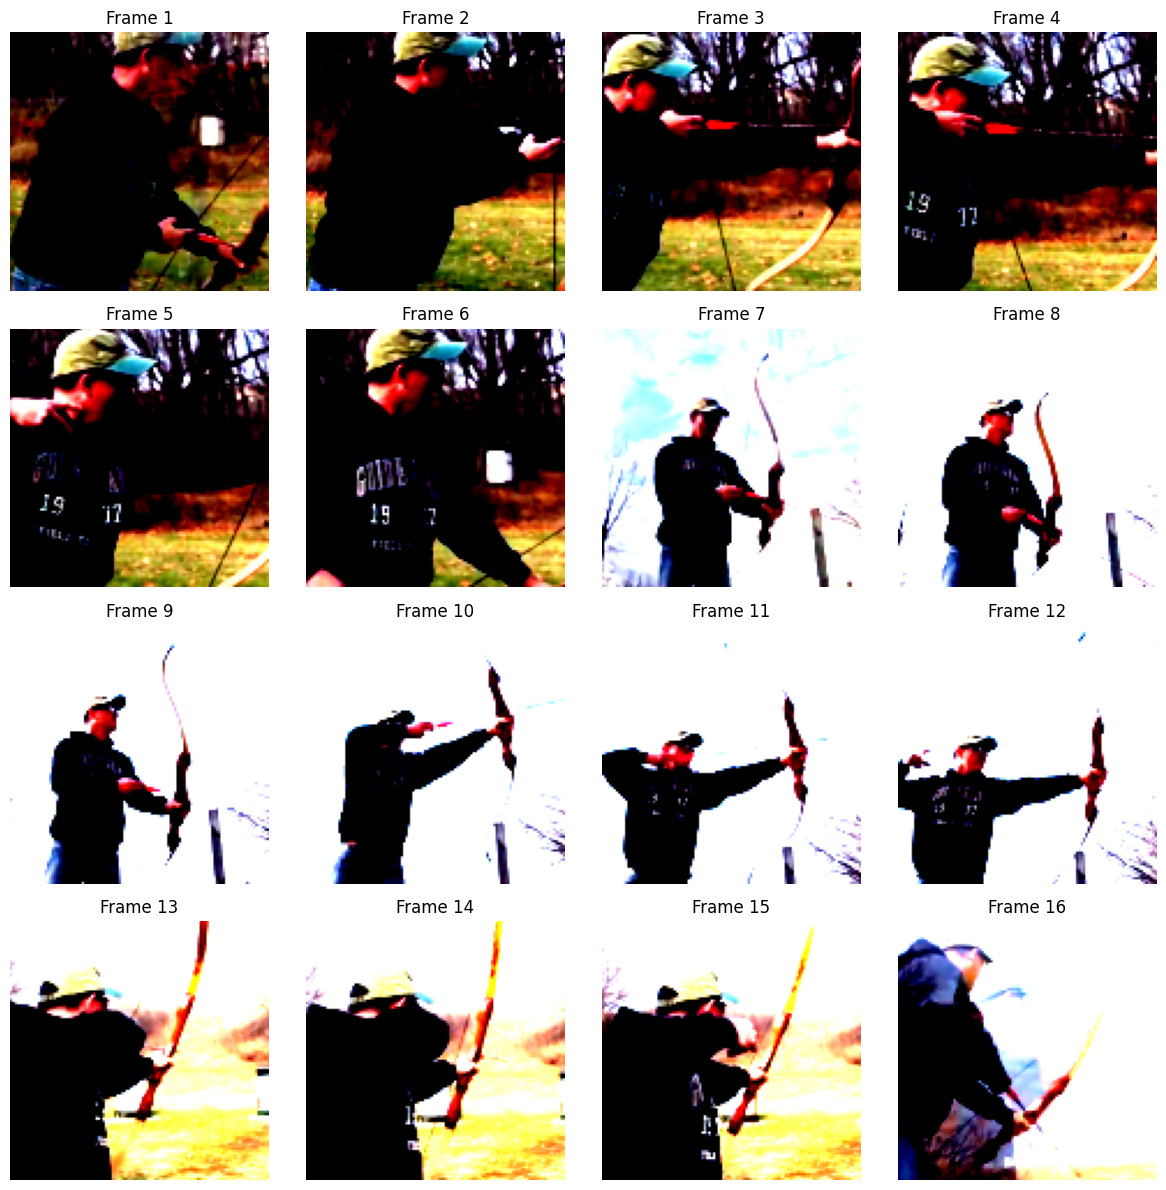

In [11]:
def show_frames(input_frames):
    """
    Displays the video frames from the input tensor.

    Args:
    - input_frames: torch.Tensor of shape [1, 3, 16, 112, 112] (video frames)
    """
    # Move tensor to CPU and convert to numpy
    frames = input_frames.squeeze(0).permute(1, 2, 3, 0).cpu().numpy()  # Shape: [16, 112, 112, 3]

    # Normalize frames to [0, 1] if they are in range [0, 255]
    if frames.max() > 1:
        frames = frames / 255.0

    # Create a figure
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()  # Ensure correct subplot indexing

    for i in range(16):
        frame = frames[i]  # Shape: [112, 112, 3]
        
        # Display result
        #frame = frame[..., ::-1]
        axes[i].imshow(frame)
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
show_frames(inputs)  # Assuming 'inputs' is the input tensor

In [12]:
#kinetics400_5per/train/archery/J6YU92u-Dxs.mp4
model.eval()
with torch.no_grad():
    logits, spatial_attention_map, temporal_attention_map = model(inputs)

In [13]:
spatial_attention_map.shape

torch.Size([1, 1, 16, 112, 112])

In [14]:
temporal_attention_map.shape

torch.Size([1, 1, 16, 1, 1])

In [15]:
spatial_attention_map

tensor([[[[[0.6508, 0.6508, 0.6508,  ..., 0.6797, 0.6603, 0.6916],
           [0.6508, 0.6508, 0.6508,  ..., 0.6617, 0.6947, 0.7966],
           [0.6508, 0.6508, 0.6508,  ..., 0.7154, 0.7513, 0.7966],
           ...,
           [0.6808, 0.7103, 0.6920,  ..., 0.6778, 0.6828, 0.6916],
           [0.6836, 0.7234, 0.7028,  ..., 0.6939, 0.7021, 0.6916],
           [0.6884, 0.7188, 0.7055,  ..., 0.6846, 0.6882, 0.6754]],

          [[0.6508, 0.6508, 0.6508,  ..., 0.7213, 0.7966, 0.7966],
           [0.6508, 0.6508, 0.6508,  ..., 0.7055, 0.7966, 0.7966],
           [0.6508, 0.6508, 0.6508,  ..., 0.6704, 0.7966, 0.7966],
           ...,
           [0.6599, 0.7520, 0.7698,  ..., 0.6952, 0.7207, 0.7228],
           [0.6921, 0.7590, 0.7561,  ..., 0.6976, 0.7056, 0.7134],
           [0.7180, 0.7775, 0.7425,  ..., 0.6950, 0.7024, 0.6996]],

          [[0.6732, 0.6866, 0.6706,  ..., 0.6508, 0.6508, 0.6508],
           [0.6619, 0.6811, 0.6677,  ..., 0.6508, 0.6535, 0.6508],
           [0.6510, 0.6706

In [16]:
temporal_attention_map

tensor([[[[[0.0606]],

          [[0.0606]],

          [[0.0607]],

          [[0.0610]],

          [[0.0610]],

          [[0.0609]],

          [[0.0618]],

          [[0.0624]],

          [[0.0623]],

          [[0.0638]],

          [[0.0652]],

          [[0.0681]],

          [[0.0650]],

          [[0.0636]],

          [[0.0616]],

          [[0.0613]]]]], device='cuda:0')

Spatial Attention

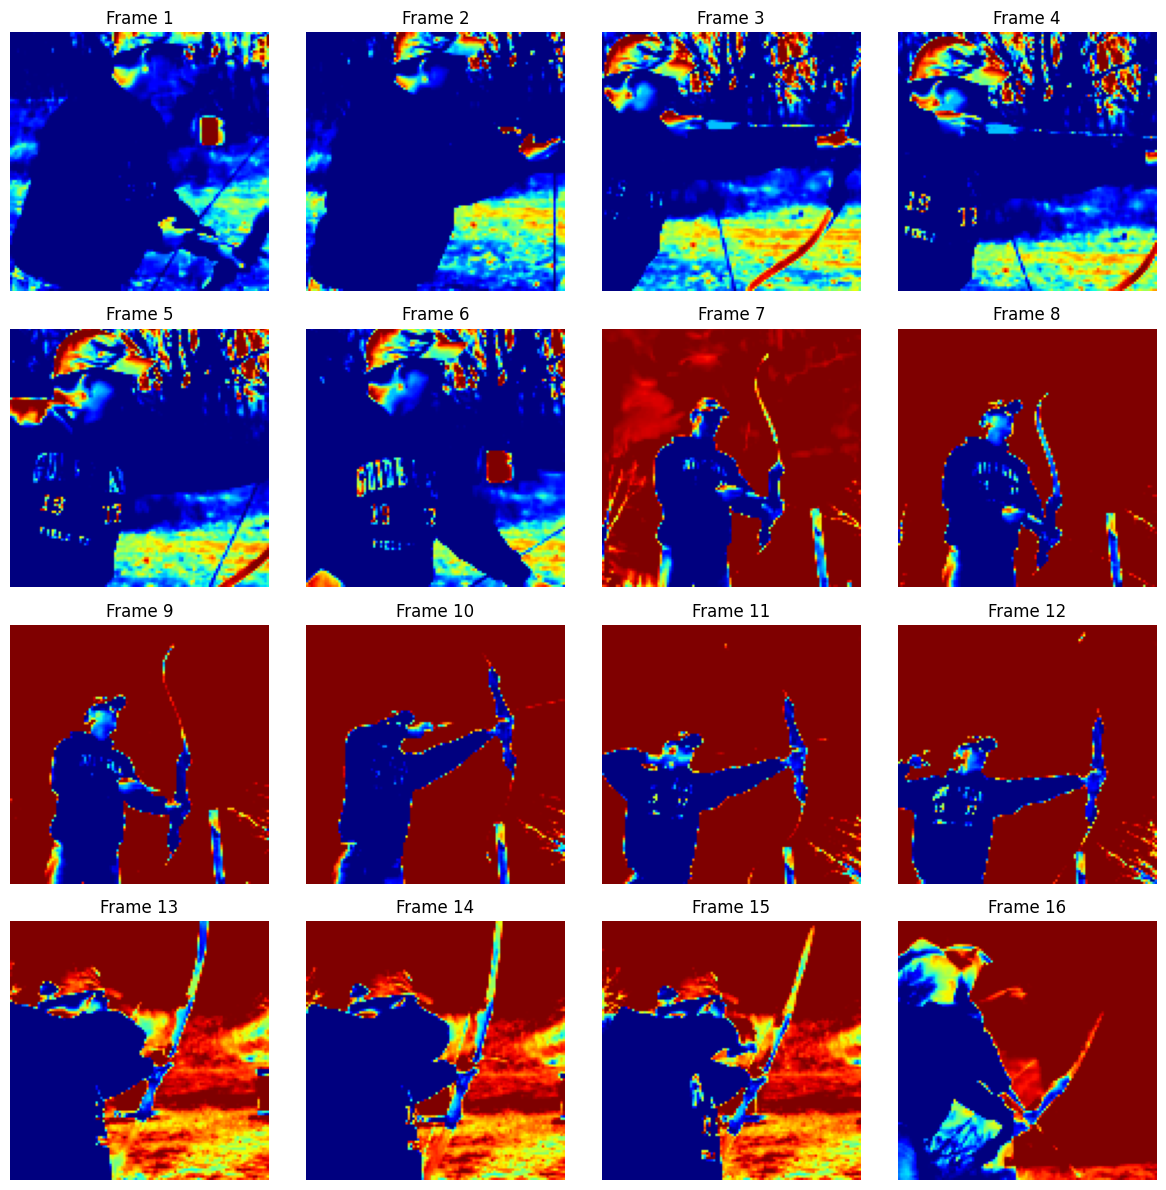

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(attention_map):
    # Ensure the tensor is in CPU and convert to numpy
    attention_map = attention_map.detach().cpu().numpy()

    # Remove batch and channel dimensions, leaving shape [16, 56, 56]
    attention_map = attention_map[0, 0]  

    # Create a figure with a 4x4 grid for 16 frames
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))

    for i in range(16):
        row, col = divmod(i, 4)  # Get row and column index for subplot
        attn = attention_map[i]

        # Min-max normalization
        attn = (attn - np.min(attn)) / (np.max(attn) - np.min(attn))

        # Plot the attention map
        axes[row, col].imshow(attn, cmap='jet')
        axes[row, col].set_title(f'Frame {i + 1}')
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Call function with your attention map
visualize_attention(spatial_attention_map)


Temporal Attention:

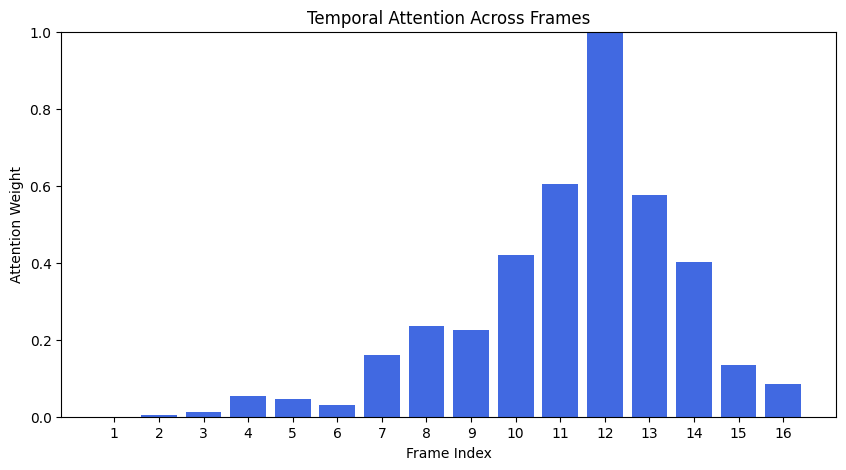

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_temporal_attention(attention_map):
    # Ensure the tensor is in CPU and convert to numpy
    attention_map = attention_map.detach().cpu().numpy()

    # Remove batch and channel dimensions, leaving shape [16]
    attention_map = attention_map[0, 0]  

    # Normalize values between 0 and 1
    attention_map = attention_map.squeeze()
    attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))

    # Create a bar plot for temporal attention
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, 17), attention_map, color='royalblue')

    # Labels and titles
    plt.xlabel("Frame Index")
    plt.ylabel("Attention Weight")
    plt.title("Temporal Attention Across Frames")
    plt.xticks(range(1, 17))  # Ensure x-axis labels match frame indices
    plt.ylim(0, 1)  # Keep y-axis in normalized range

    # Show plot
    plt.show()

# Call function with your temporal attention map
visualize_temporal_attention(temporal_attention_map)


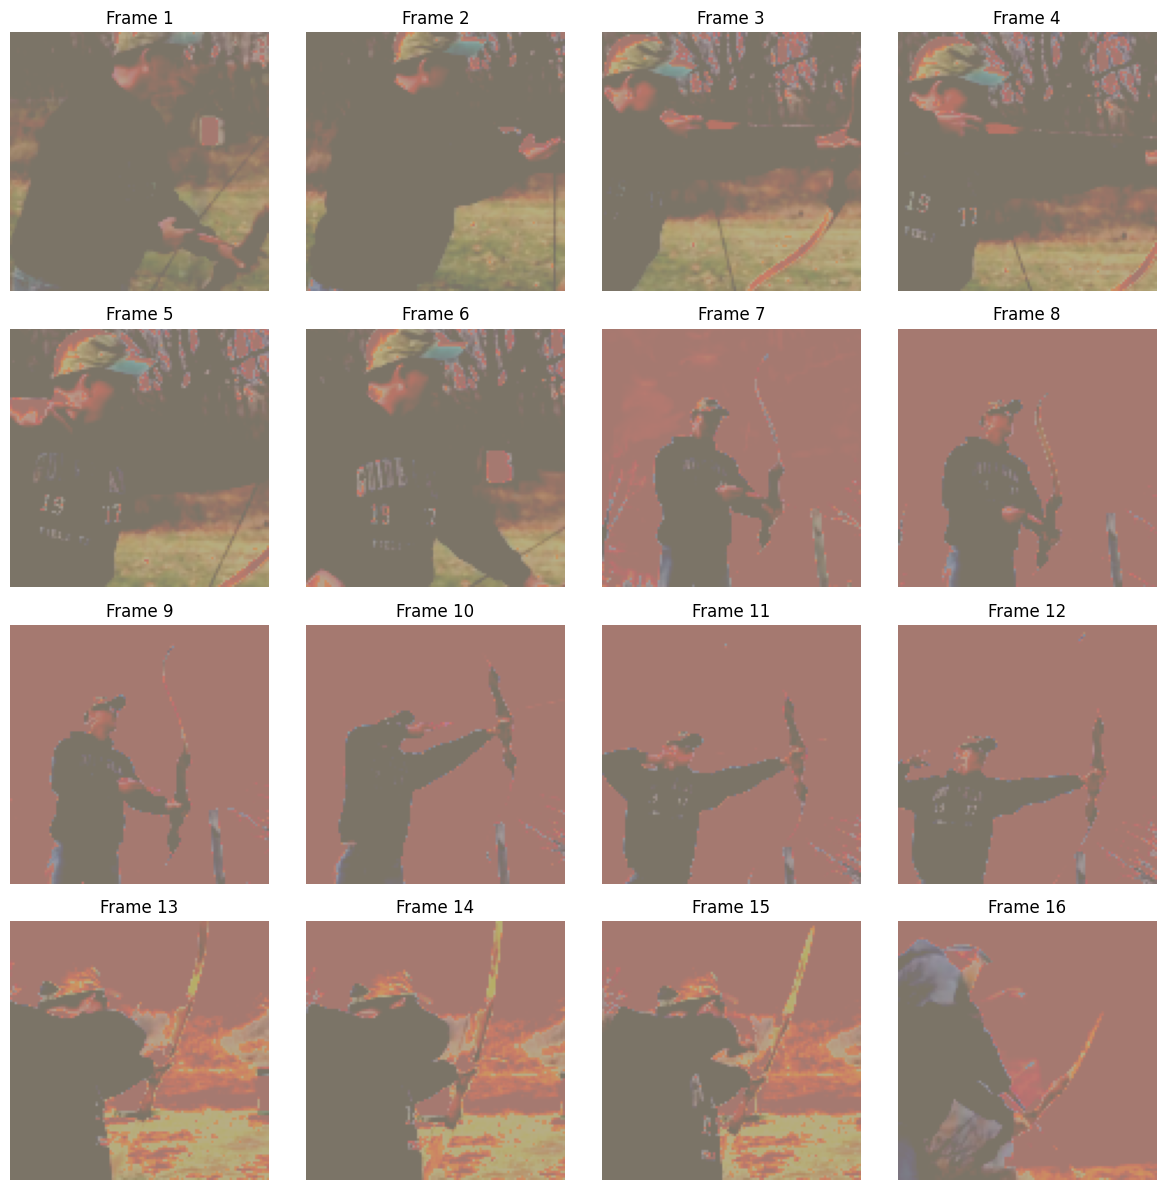

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for resizing

def overlay_high_attention(input_frames, attention_maps, alpha=0.3, threshold=0.8):
    """
    Overlays spatial attention maps onto RGB frames, but only in high-attention areas.
    Low-attention areas will show the original frame.

    Args:
    - input_frames: torch.Tensor of shape [1, 3, 16, 112, 112] (video frames)
    - attention_maps: torch.Tensor of shape [1, 1, 16, 56, 56] (spatial attention maps)
    - alpha: float, blending factor for overlay (0 = no overlay, 1 = full overlay)
    - threshold: float, only overlay attention values above this threshold
    """

    # Move tensors to CPU and convert to numpy
    frames = input_frames.squeeze(0).permute(1, 2, 3, 0).cpu().numpy()  # Shape: [16, 112, 112, 3]
    attention_maps = attention_maps.squeeze(0).squeeze(0).cpu().numpy()  # Shape: [16, 56, 56]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    frames = frames * std + mean

    frames = np.clip(frames, 0, 1)

    # Create a figure
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()  # Ensure correct subplot indexing

    for i in range(16):
        frame = frames[i]  # Shape: [112, 112, 3]
        attn = attention_maps[i]  # Shape: [56, 56]

        # Resize attention map to match frame size (112x112)
        attn_resized = cv2.resize(attn, (112, 112), interpolation=cv2.INTER_LINEAR)

        # Normalize attention map to [0,1], handling division by zero
        if attn_resized.max() > attn_resized.min():
            attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())
        else:
            attn_resized = np.zeros_like(attn_resized)

        # Create a binary mask for high-attention areas
        mask = attn_resized > threshold  # Areas where attention is high (e.g., > 0.7)

        # Convert attention map to colormap (jet colormap)
        attn_colored = plt.cm.jet(attn_resized)[:, :, :3]  # Shape: [112, 112, 3]

        # Create a new frame where only high-attention areas are blended with the attention color
        overlay = frame.copy()  # Start with the original frame
        overlay[mask] = (1 - alpha) * frame[mask] + alpha * attn_colored[mask]  # Blend for high-attention areas

        # Ensure values are in range [0,1] for visualization
        overlay = np.clip(overlay, 0, 1)

        # Display result
        axes[i].imshow(overlay)
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
overlay_high_attention(inputs, spatial_attention_map)
